<a href="https://colab.research.google.com/github/LDrago27/appliedDlCancer/blob/main/CourseProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Openslide utility

In [ ]:
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (97.9 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 124013 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import cv2
import random
import tensorflow as tf

In [ ]:
# Download an example slide and tumor mask

# Note: the remainder of the training data are in the Google Drive folder linked above.
# You will need to host them on your own, either in Google Drive, or by using
# the cloud provider of your choice.

slide_path = 'tumor_091.tif' # only this file is available
tumor_mask_path = 'tumor_091_mask.tif' # only this file is available

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0  49.9M      0  0:00:10  0:00:10 --:--:-- 59.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  20.9M      0 --:--:-- --:--:-- --:--:-- 20.9M


In [ ]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

# What is meant by slide level
# It refers to resolutions of the same image



Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [ ]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

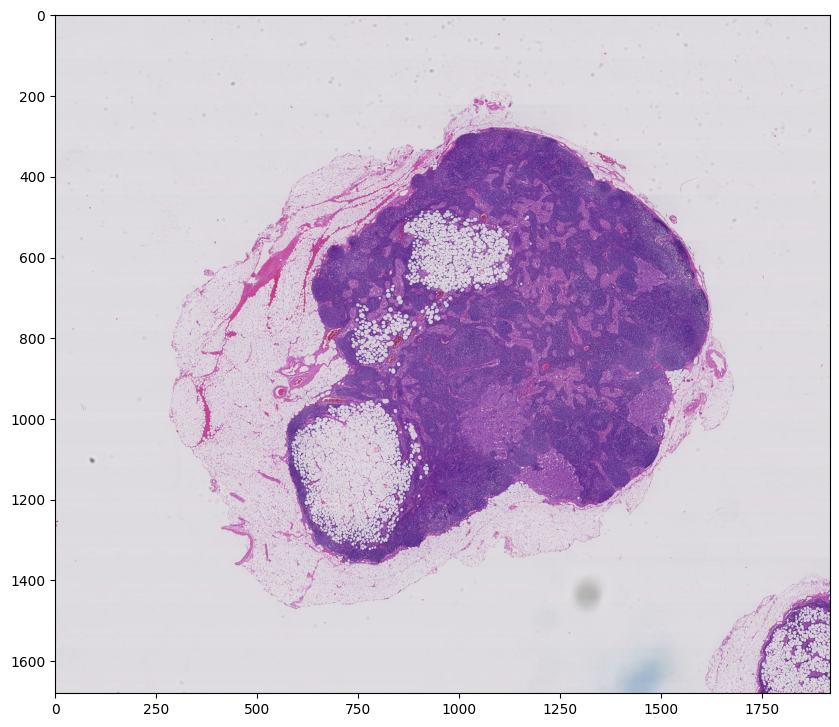

In [ ]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

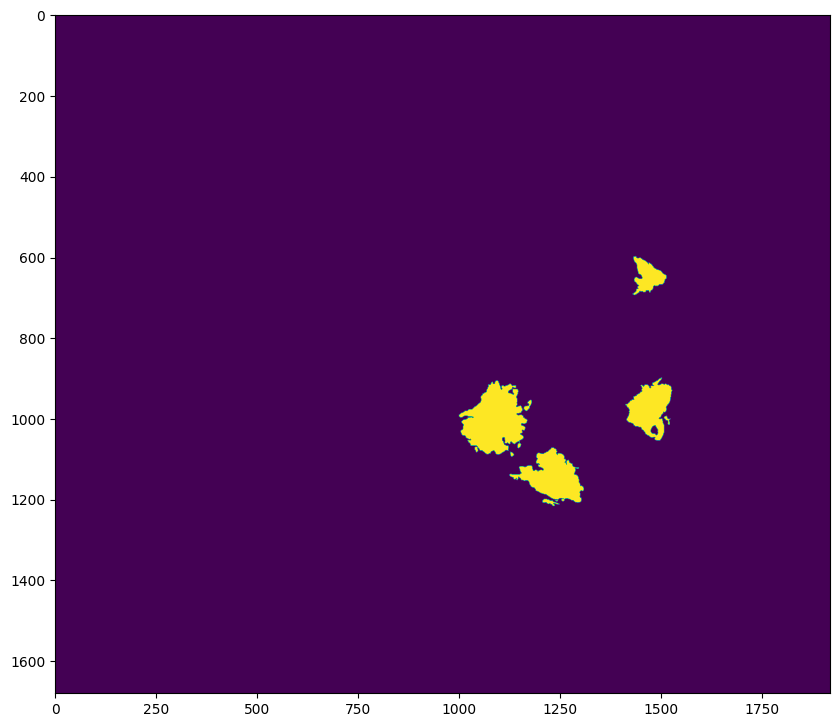

In [ ]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=5, 
                        width=slide.level_dimensions[5][0], 
                        height=slide.level_dimensions[5][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

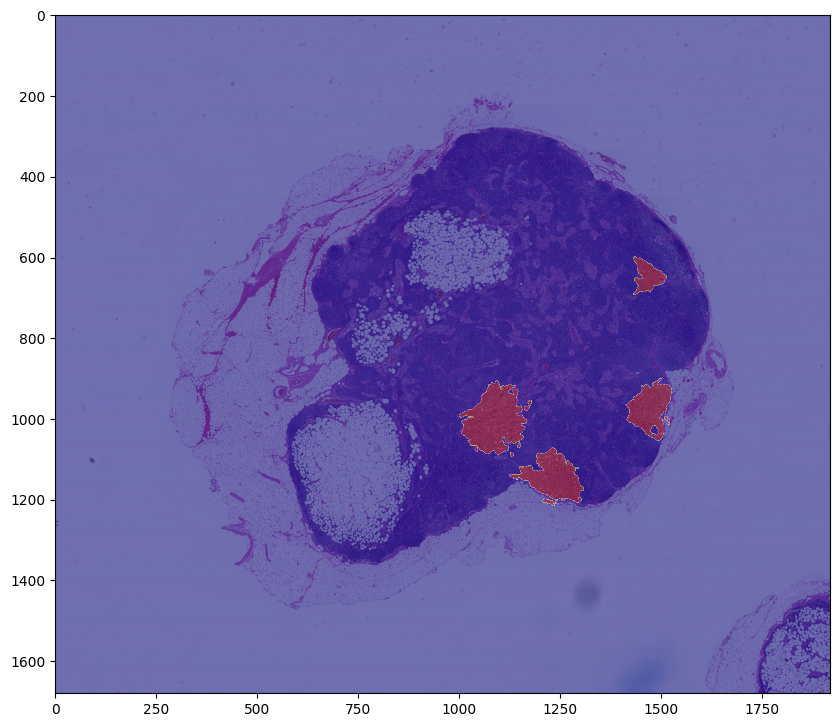

In [ ]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

1


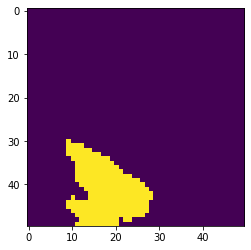

In [ ]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
print(np.max(region))
plt.imshow(region)

905504 tissue_pixels pixels (32.1 percent of the image)


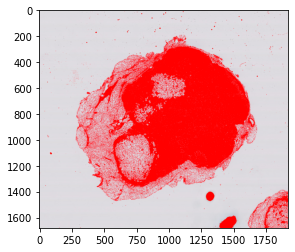

In [ ]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[0]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

## Creating a Sliding window to generate 299X299 slides

In [ ]:
def containsTissue(image, intensity=0.8, threshold = 10):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    res = list(zip(indices[0], indices[1]))

    percent_tissue = len(res) / float(image.shape[0] * image.shape[0]) * 100
    return percent_tissue>=threshold
    

def generateDataset(slide,tumorMask, dirpath, maskPath, maglevel = 5, strideLength = 10 ,windowWidth = 299, windowHt= 299, initX = 0, initY = 0, earlyStop = 0 ):
  '''
  Aim of the function to generate two folders at dirpath with names cancer and benign depending
  '''
  
  
  totalWidth, totalHt = slide.level_dimensions[maglevel]
  
  # Creating a cancer and bengin folder in the main 
  cancerBasePath = os.path.join(dirpath,"cancer")
  maskCancerBasePath = os.path.join(maskPath,"cancer")
  benignBasePath = os.path.join(dirpath,"benign")
  maskBenginBasePath = os.path.join(maskPath,"benign")
  
  if not os.path.exists(cancerBasePath):
    os.mkdir(cancerBasePath)
  if not os.path.exists(maskCancerBasePath):
    os.mkdir(maskCancerBasePath)
  if not os.path.exists(benignBasePath):
    os.mkdir(benignBasePath)
  if not os.path.exists(maskBenginBasePath):
    os.mkdir(maskBenginBasePath)

  ctr = len(os.listdir(cancerBasePath))+len(os.listdir(benignBasePath))+1

  print("Starting Level:"+str(maglevel))
  for x in range(initX,totalHt-windowHt,strideLength):

    for y in range(initY,totalWidth-windowWidth,strideLength):

      scaleTempx,scaleTempy = int(x*slide.level_downsamples[maglevel]), int(y*slide.level_downsamples[maglevel])
      slideImage = read_slide(slide, 
                          scaleTempx, 
                          scaleTempy, 
                          level=maglevel, 
                          width=windowWidth, 
                          height=windowHt)
      
      tumorImage = read_slide(tumor_mask, scaleTempx, 
                          scaleTempy, 
                          level=maglevel, 
                          width=windowWidth, 
                          height=windowHt)[:,:,0]

      tumorIndicator = np.max(tumorImage) 

      # If the given Image doesn't have any tissue region ignore it
      if not containsTissue(slideImage):
        continue

      if tumorIndicator == 1:
        # it has a tumor so place it in tumor image folder
        imagePath = os.path.join(cancerBasePath,"img"+str(ctr)+".png")
        maskPath = os.path.join(maskCancerBasePath,"img"+str(ctr)+".png")
      else:
        # placce it in benign folder
        imagePath = os.path.join(benignBasePath,"img"+str(ctr)+".png")
        maskPath = os.path.join(maskBenginBasePath,"img"+str(ctr)+".png")

      cv2.imwrite(imagePath,slideImage)
      cv2.imwrite(maskPath,tumorImage)
      ctr+=1

      if ctr%2000 == 0:
        print("Completed Images:"+str(ctr))


In [ ]:
import shutil
shutil.rmtree("Slide-002")

NotADirectoryError: ignored

In [ ]:
path = "091"
os.mkdir(path)
newLevel = os.path.join(path,'5')
os.mkdir(newLevel)

os.mkdir("Mask")
maskPath =  os.path.join("Mask",path)
os.mkdir(maskPath)
maskPath = os.path.join(maskPath,'5')
os.mkdir(maskPath)

In [ ]:
generateDataset(slide, tumor_mask , newLevel, maskPath, maglevel = 5, strideLength = 10 ,windowWidth = 299, windowHt= 299, initX = 0, initY = 0, earlyStop = 0 )

## Sanity Testing

In [ ]:
cancerDir = list(os.listdir(os.path.join(newLevel,"cancer")))
benignDir = list(os.listdir(os.path.join(newLevel,"benign")))
maskCancerDir = list(os.listdir(os.path.join(maskPath,"cancer")))
maskBenignDir = list(os.listdir(os.path.join(maskPath,"benign")))
cancerDir.sort()
benignDir.sort()
maskCancerDir.sort()
maskBenignDir.sort()

In [ ]:
# stats 
print("No of cancer Image:",len(cancerDir))
print("No of benign Image:", len(benignDir))

No of cancer Image: 4492
No of benign Image: 12583


(299, 299, 3)
(299, 299)


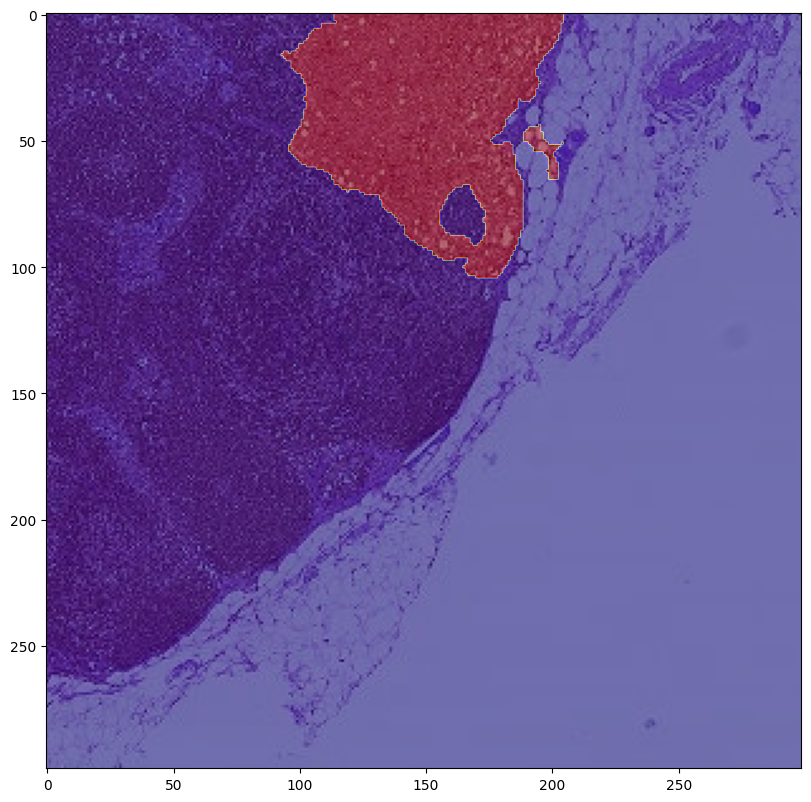

In [ ]:
# Visualizing some of the Image
randomCancerIndex = random.randint(0,len(cancerDir)-1)
cancerImage = plt.imread(os.path.join(newLevel,"cancer",cancerDir[randomCancerIndex]))
mask = plt.imread(os.path.join(maskPath,"cancer",maskCancerDir[randomCancerIndex]))

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(cancerImage)
plt.imshow(mask, cmap='jet', alpha=0.5)

print(cancerImage.shape)
print(mask.shape)

(299, 299, 3)
(299, 299)


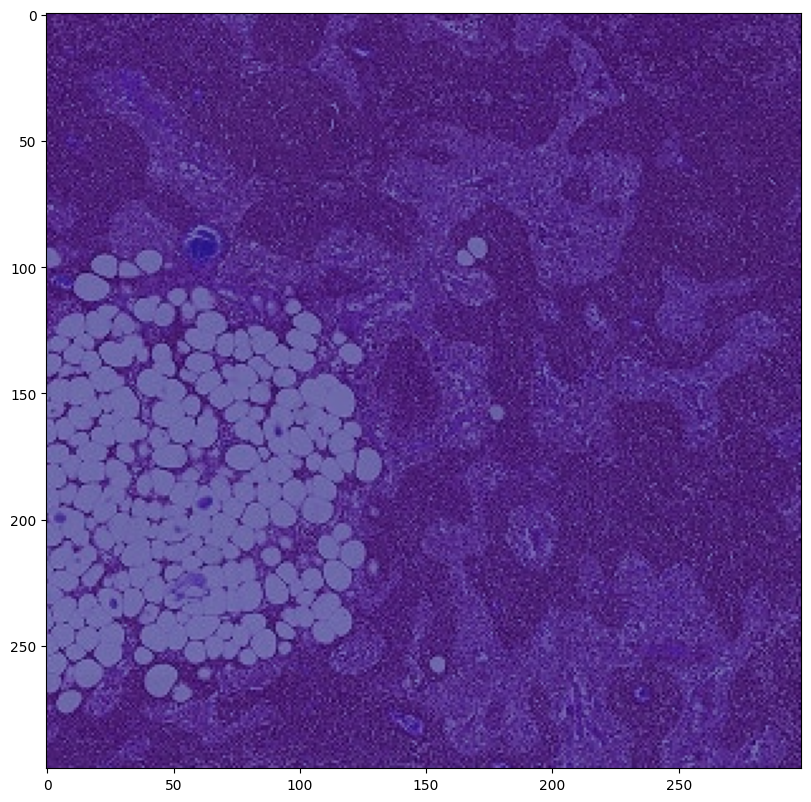

In [ ]:
randomBenignIndex = random.randint(0,len(benignDir)-1)
benignImage = plt.imread(os.path.join(newLevel,"benign",benignDir[randomBenignIndex]))
mask = plt.imread(os.path.join(maskPath,"benign",maskBenignDir[randomBenignIndex]))

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(benignImage)
plt.imshow(mask, cmap='jet', alpha=0.5)

print(benignImage.shape)
print(mask.shape)

## Creating Function that would create the dataset from 4 different levels. results of each level will be present in their Separate Folder

In [ ]:
def createDataSetLevel(slide,mask):
  magLevels = [1,2,5,6]
  basePath = "project"
  maskPath = "mask"
  strideLength = 100

  if not os.path.exists(basePath):
    os.mkdir(basePath)
  if not os.path.exists(maskPath):
    os.mkdir(maskPath)

  for level in magLevels:
    dirPath = os.path.join(basePath,str(level))
    maskDirPath = os.path.join(maskPath,str(level))

    if not os.path.exists(dirPath):
      os.mkdir(dirPath)
    if not os.path.exists(maskDirPath):
      os.mkdir(maskDirPath)

    generateDataset(slide,mask, dirPath, maskDirPath, maglevel = level,strideLength = strideLength//level)


In [ ]:
createDataSetLevel(slide,tumor_mask)

Starting Level:1


KeyboardInterrupt: ignored

## Reading Multiple Slides and creating Dataset out of them

In [ ]:
def download_if_missing(url, target, extract=True):
  return tf.keras.utils.get_file(target, origin=url, extract=extract)


In [ ]:
storageBucketUrl = 'https://storage.googleapis.com/applieddlproject/slides-20221213T034428Z-%s'
buckets = ['001','002','003','004','007','008','017','020']

if not os.path.exists("Slides"):
  os.mkdir("Slides")

for bucket in buckets:
  target = os.path.join(os.getcwd(), "Slide.zip")
  storageUrl = storageBucketUrl %bucket+".zip"
  download_if_missing(storageUrl, target, extract=False)

  slideLocation = os.path.join(os.getcwd(), "Slides",bucket)

  if not os.path.exists(slideLocation):
    os.mkdir(slideLocation)
  
  !unzip -q $target -d $slideLocation

  os.remove(target)



1243891100/1243891100 [==============================] - 8s 0us/step


In [ ]:
import shutil
pathSlides = "AllSlides"
if not os.path.exists(pathSlides):
  os.mkdir(pathSlides)
dirEle = list(os.listdir("Slides"))
for ele in dirEle:
  folderPath = os.path.join("Slides",ele,"slides")
  for file in os.listdir(folderPath):
    try: 
      shutil.copy(os.path.join(folderPath,file),pathSlides)
    except:
      continue



In [ ]:
import pathlib

filesList = os.listdir("AllSlides")
baseLocation = "AllSlides"
ctr = 0
netSlideCount = 3

for file in filesList:
  fileObj = pathlib.Path(file)
  fname,extension = fileObj.stem, fileObj.suffix
  #print(fname,extension)
  if extension == '.xml' or fname=="tumor_091" or fname=="tumor_035":
    continue

  slidePath = os.path.join(baseLocation,fname+".tif")
  tumorPath = os.path.join(baseLocation,fname+"_mask.tif")

  if not (os.path.exists(slidePath) and os.path.exists(tumorPath)):
    continue

  slide = open_slide(slidePath)
  tumor_mask = open_slide(tumorPath)

  print ("Read WSI from %s with width: %d, height: %d" % (slidePath, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

  print ("Read WSI from %s with width: %d, height: %d" % (tumorPath, 
                                                        tumor_mask.level_dimensions[0][0], 
                                                        tumor_mask.level_dimensions[0][1]))

  print("Generating DataSet for File:",fname)
  createDataSetLevel(slide,tumor_mask)

  ctr+=1

  if ctr == netSlideCount:
    break

Generating DataSet for File: tumor_035
Starting Level:1
Completed Images:48000
Completed Images:50000
Completed Images:52000
Completed Images:54000
Completed Images:56000
Completed Images:58000
Completed Images:60000
Completed Images:62000
Completed Images:64000
Completed Images:66000
Completed Images:68000
Completed Images:70000
Completed Images:72000
Completed Images:74000
Completed Images:76000
Completed Images:78000
Completed Images:80000
Completed Images:82000
Completed Images:84000
Completed Images:86000
Completed Images:88000
Completed Images:90000
Completed Images:92000
Completed Images:94000
Completed Images:96000
Completed Images:98000
Completed Images:100000
Completed Images:102000
Completed Images:104000
Completed Images:106000
Completed Images:108000
Completed Images:110000
Completed Images:112000
Completed Images:114000
Completed Images:116000
Completed Images:118000
Completed Images:120000
Completed Images:122000
Completed Images:124000
Completed Images:126000
Completed 

KeyboardInterrupt: ignored